In [1]:
import matplotlib.pyplot as plt
import os

In [2]:
classes = sorted(os.listdir('data/'))
print("Total Classes: ", len(classes))

Total Classes:  22


In [3]:
total_images = 0
for i in classes:
    class_dir = "data/" + str(i) + "/"
    path, dirs, files = next(os.walk(class_dir))
    file_count = len(files)
    total_images += file_count
    print("Total images in ", i, ": \t", file_count)
    
print("\nTotal Images in Dataset: ", total_images)

Total images in  badminton : 	 938
Total images in  baseball : 	 746
Total images in  basketball : 	 495
Total images in  boxing : 	 705
Total images in  chess : 	 481
Total images in  cricket : 	 715
Total images in  fencing : 	 635
Total images in  football : 	 799
Total images in  formula1 : 	 687
Total images in  gymnastics : 	 719
Total images in  hockey : 	 572
Total images in  ice_hockey : 	 715
Total images in  kabaddi : 	 454
Total images in  motogp : 	 679
Total images in  shooting : 	 536
Total images in  swimming : 	 689
Total images in  table_tennis : 	 713
Total images in  tennis : 	 718
Total images in  volleyball : 	 713
Total images in  weight_lifting : 	 577
Total images in  wrestling : 	 611
Total images in  wwe : 	 671

Total Images in Dataset:  14568


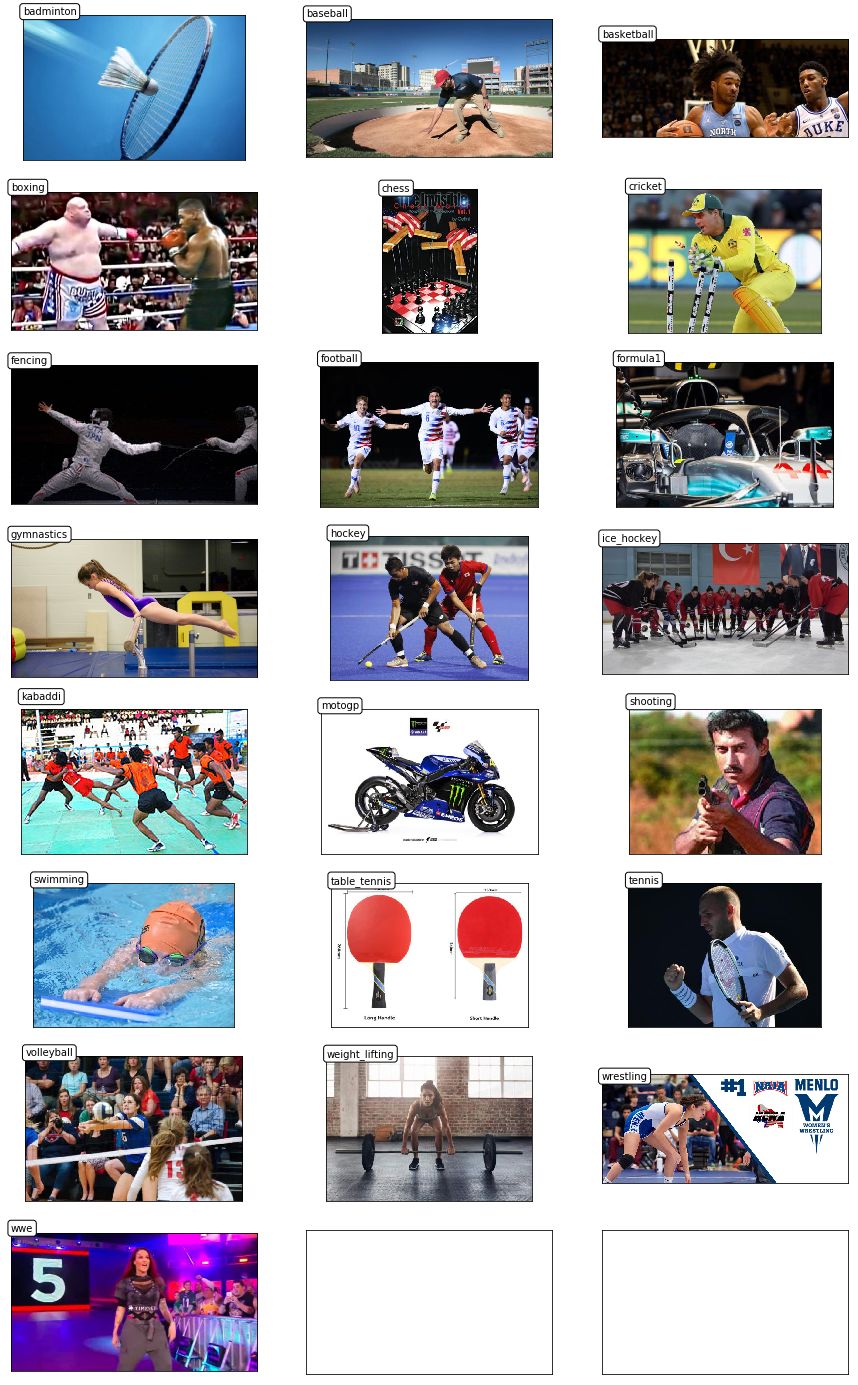

In [4]:
import random

root_dir = 'data/'
rows, cols = 8, 3
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
classes = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            sports_dir = classes[i*cols + j]
        except:
            break
        img = random.choice(os.listdir(root_dir + sports_dir + '/'))
        img = root_dir + sports_dir+'/'+img
        img = plt.imread(img)
        ax[i][j].imshow(img)
        ax[i][j].text(0, -20, sports_dir, size=10, rotation=0, ha="left", va="top", 
                      bbox=dict(boxstyle="round", ec="black", fc="white"))
    plt.setp(ax, xticks=[], yticks=[])

In [5]:
plt.style.use('ggplot')
import numpy as np
import argparse
import pickle
import cv2
from imutils import paths

In [6]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.pooling import AveragePooling2D
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
LABELS = set(["weight_lifting", "tennis", "football"])
 
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data"))
data = []
labels = []
 
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
    
	if label not in LABELS:
		continue
 
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
 
	data.append(image)
	labels.append(label)

print("[INFO] images loaded...")

[INFO] loading images...
[INFO] images loaded...


In [8]:
data = np.array(data)
labels = np.array(labels)
 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

In [9]:
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
 
valAug = ImageDataGenerator()
 
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [10]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
 
model = Model(inputs=baseModel.input, outputs=headModel)
 
for layer in baseModel.layers:
	layer.trainable = False

c:\users\kunwa\appdata\local\programs\python\python35\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0722 18:57:19.222212  5116 deprecation.py:506] From c:\users\kunwa\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])
 
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=50)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
48/48 [==============================] - 58s 1s/step - loss: 1.2399 - acc: 0.4046 - val_loss: 0.9863 - val_acc: 0.5254
Epoch 2/50
48/48 [==============================] - 44s 909ms/step - loss: 1.0484 - acc: 0.5013 - val_loss: 0.7800 - val_acc: 0.6465
Epoch 3/50
48/48 [==============================] - 20s 416ms/step - loss: 0.8806 - acc: 0.6086 - val_loss: 0.6924 - val_acc: 0.7031
Epoch 4/50
48/48 [==============================] - 20s 424ms/step - loss: 0.8016 - acc: 0.6645 - val_loss: 0.6242 - val_acc: 0.7422
Epoch 5/50
48/48 [==============================] - 21s 438ms/step - loss: 0.7139 - acc: 0.7118 - val_loss: 0.5541 - val_acc: 0.7598
Epoch 6/50
48/48 [==============================] - 21s 448ms/step - loss: 0.6594 - acc: 0.7276 - val_loss: 0.5281 - val_acc: 0.7773
Epoch 7/50
48/48 [==============================] - 21s 444ms/step - loss: 0.6112 - acc: 0.7566 - val_loss: 0.4979 - val_acc: 0.7852
Epoch 8/50
48/48 [====

[INFO] evaluating network...
                precision    recall  f1-score   support

      football       0.82      0.96      0.89       196
        tennis       0.87      0.87      0.87       179
weight_lifting       0.97      0.74      0.84       143

      accuracy                           0.87       518
     macro avg       0.89      0.86      0.86       518
  weighted avg       0.88      0.87      0.87       518



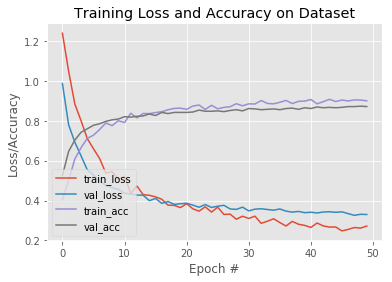

In [12]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))
 
N = 50
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output.png")

In [14]:
print("[INFO] serializing network...")
model.save("model/activity.model")
 
f = open("model/lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network...
